In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import cv2
import fast.s26_analysis.utils as utils
import joblib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import odl
import skimage
import tifffile as tif
from cycler import cycler
from fast.utils.generate_scan_pattern import generate_scan_pattern as gcn
from fast.utils.img_loader import renormalize
from tqdm.notebook import tqdm

In [3]:
frbh = lambda x, m: skimage.restoration.inpaint_biharmonic(x * m, (1 - m).astype("bool"))
frns = lambda x, m: cv2.inpaint(x * m, 1 - m, 10, cv2.INPAINT_NS)

In [4]:
shape = np.array([128, 128])
center = shape // 2

In [5]:
space = odl.uniform_discr([-1, -1], [1, 1], shape)

In [6]:
base_dir = Path("features_densities/")

In [7]:
2 ** (4)

16

[  10.   20.   30.   40.  100.]
Nonzero orig 6583
Nonzero sum 6583
[  10.   20.   30.   40.  100.]
Nonzero orig 1569
Nonzero sum 6276
[  10.   20.   30.   40.  100.]
Nonzero orig 352
Nonzero sum 5632
[  20.   30.  100.]
Nonzero orig 73
Nonzero sum 4672


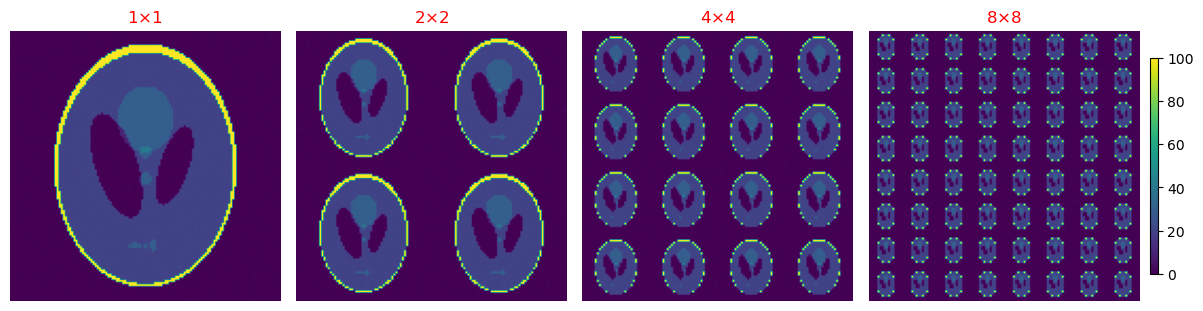

In [8]:
sps_scaled = {}
shapes_scaled = {}

fig, axs = plt.subplots(1, 4, figsize=[12, 3], constrained_layout=True)

for i in range(4):
    shape_this = shape // 2**i
    space_this = odl.uniform_discr([-1, -1], [1, 1], shape=shape_this)

    space_this_2 = odl.uniform_discr([-1, -1], [1, 1], shape=shape_this - 2)
    sp_orig = odl.phantom.shepp_logan(space_this_2, modified=True).asarray().T[::-1]  # * 100 + 0.9
    sp_orig = renormalize(sp_orig)
    sp_orig = np.pad(sp_orig, [1, 1])
    sp_nonzero = sp_orig[sp_orig > 0]
    print(np.unique(sp_nonzero))
    print("Nonzero orig", np.sum(sp_orig > 0))

    # shape_new = sp_this.shape
    # sp_this = np.pad(sp_orig, [64 - shape_this // 2, 64 - shape_this // 2])
    sp_this = np.tile(sp_orig, (2**i, 2**i))
    print("Nonzero sum", np.sum(sp_this > 0))
    noise_this = odl.phantom.noise.white_noise(space, stddev=0.5).asarray()
    sp_this += noise_this

    label = rf"{2**i}$\times${2**i}"
    cim = axs[i].imshow(sp_this, vmin=0, vmax=100, rasterized=False)

    # axs[i].set_ylim(roi[0], roi[1])
    # axs[i].set_xlim(roi[0], roi[1])
    axs[i].set_title(label, color="red")
    axs[i].axis("off")

    sps_scaled[i] = renormalize(sp_this)
    shapes_scaled[i] = shape_this


fig.colorbar(ax=axs, mappable=cim, pad=0.01, shrink=0.8, use_gridspec=True, aspect=30)
# plt.savefig(f"{base_dir}/ground.svg", bbox_inches="tight", transparent=True, dpi=300)
plt.savefig(f"{base_dir}/ground.pdf", bbox_inches="tight", transparent=True, dpi=300)
plt.show()

In [9]:
!du -hc features_densities/*

16K	features_densities/comparisons_multiple.pdf
57M	features_densities/data_all.joblib
80K	features_densities/ground.pdf
57M	total


In [21]:
load_fname = base_dir / "data_all.joblib"

In [22]:
data_per_label = joblib.load(load_fname)

In [23]:
markers = cycler(marker=[".", "o", "D", "<", "s", "P", "X", "D", 9, 10, "d"])
linestyle_tuple = ls = [
    ("loosely dotted", (0, (1, 10))),
    ("dotted", (0, (1, 1))),
    ("densely dotted", (0, (1, 1))),
    ("densely dashdotdotted", (0, (3, 1, 1, 1, 1, 1))),
    ("dashdotdotted", (0, (3, 5, 1, 5, 1, 5))),
    ("dashed", (0, (5, 5))),
    ("densely dashed", (0, (5, 1))),
    ("dashdotted", (0, (3, 5, 1, 5))),
    ("densely dashdotted", (0, (3, 1, 1, 1))),
    ("loosely dashdotdotted", (0, (3, 10, 1, 10, 1, 10))),
    ("densely dashdotdotted", (0, (3, 1, 1, 1, 1, 1))),
]
ls_cycler = [l[1] for l in linestyle_tuple]
prop_cycler = markers + cycler(ls=ls_cycler)

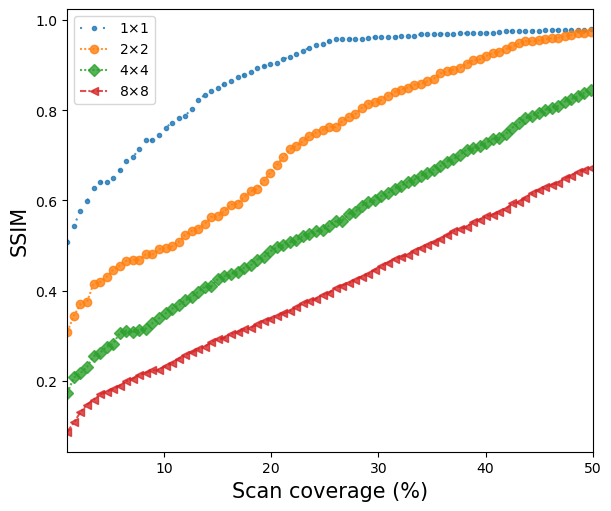

In [24]:
pc = prop_cycler()
plt.figure(figsize=[6, 5], constrained_layout=True)
for ix, k in enumerate(data_per_label):
    shape_this = shapes_scaled[k]
    label = rf"{2**ix}$\times${2**ix}"
    plt.plot(data_per_label[k]["scan_ratios"] * 100, data_per_label[k]["ssims"], label=label, **next(pc), alpha=0.8)

plt.xlabel("Scan coverage (%)", fontsize=15)
plt.ylabel("SSIM", fontsize=15)
plt.legend(loc="best")

# plt.text(28, 0.8, r'$27\%$', size=18)
# plt.axvline(27, ls=':')
plt.xlim([1, 50])
# plt.savefig(f"{base_dir}/ssims.svg", bbox_inches="tight", dpi=600, transparent=True)
plt.savefig(f"{base_dir}/ssims.pdf", bbox_inches="tight", dpi=600, transparent=True)
plt.show()

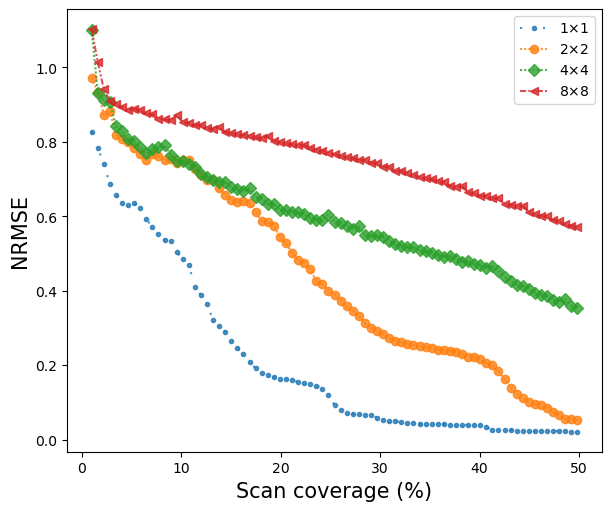

In [25]:
pc = prop_cycler()
plt.figure(figsize=[6, 5], constrained_layout=True)
for ix, k in enumerate(data_per_label):
    shape_this = shapes_scaled[k]
    label = rf"{2**ix}$\times${2**ix}"
    plt.plot(data_per_label[k]["scan_ratios"] * 100, data_per_label[k]["rmses"], label=label, alpha=0.8, **next(pc))

plt.xlabel("Scan coverage (%)", fontsize=15)
plt.ylabel("NRMSE", fontsize=15)
plt.legend(loc="best")

# plt.text(28, 0.8, r'$27\%$', size=18)
# plt.axvline(27, ls=':')
# plt.xlim([1, 40])
plt.savefig(f"{base_dir}/nrmses.svg", bbox_inches="tight", dpi=600, transparent=True)
plt.savefig(f"{base_dir}/nrmses.pdf", bbox_inches="tight", dpi=600, transparent=True)
plt.show()

In [34]:
ratios_to_plot = [15, 30]
indices = [np.argmin(np.abs(data_per_label[0]["scan_ratios"] * 100 - r)) for r in ratios_to_plot]

In [35]:
indices

[23, 48]

In [36]:
center = shape // 2

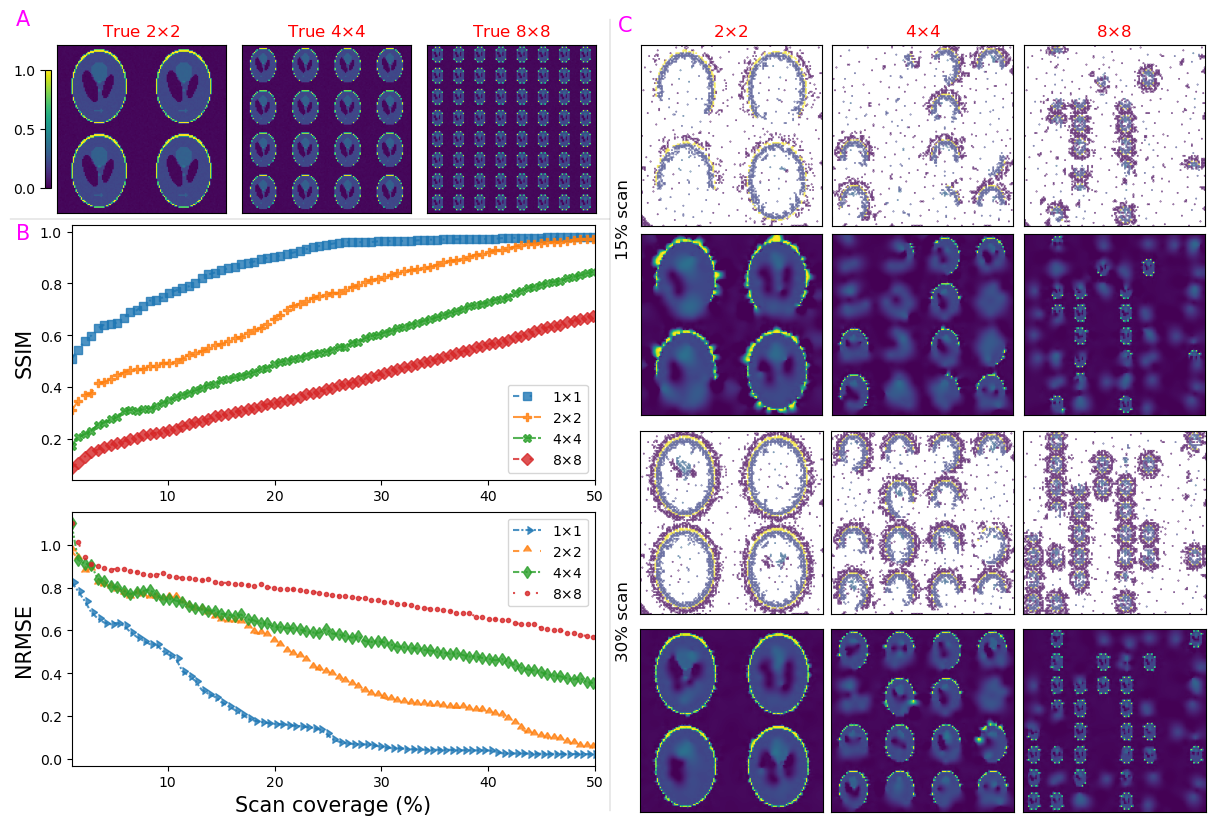

In [158]:
cmap = mpl.colormaps.get_cmap("viridis").copy()
norm = plt.Normalize(0, 1)
fig = plt.figure(figsize=[12, 8], constrained_layout=True)
gs = fig.add_gridspec(4, 6)

sf1 = fig.add_subfigure(gs[0, :3])
axs = sf1.subplots(1, 3)

iy = 0
for label in data_per_label:
    if label == 0:
        continue
    title = rf"True {2**(iy+1)}$\times${2**(iy+1)}"
    sp_this = sps_scaled[label] / 100
    cim = axs[iy].imshow(sp_this, norm=norm, cmap=cmap, rasterized=False)
    axs[iy].set_title(title, color="red")  # , fontsize=12)
    iy += 1
plt.setp(axs, yticks=[])
plt.setp(axs, xticks=[])
cbar = sf1.colorbar(cim, ax=axs, shrink=0.7, pad=0.01, location="left")
cbar.ax.set_yticks([0, 0.5, 1.0])

sf2 = fig.add_subfigure(gs[1:4, :3])
sp = sf2.add_subplot(211)
for ix, k in enumerate(data_per_label):
    shape_this = shapes_scaled[k]
    label = rf"{2**ix}$\times${2**ix}"
    sp.plot(data_per_label[k]["scan_ratios"] * 100, data_per_label[k]["ssims"], label=label, **next(pc), alpha=0.8)

plt.ylabel("SSIM", fontsize=15)
plt.legend(loc="best")
plt.xlim([1, 50])

sp = sf2.add_subplot(212)
for ix, k in enumerate(data_per_label):
    shape_this = shapes_scaled[k]
    label = rf"{2**ix}$\times${2**ix}"
    sp.plot(data_per_label[k]["scan_ratios"] * 100, data_per_label[k]["rmses"], label=label, **next(pc), alpha=0.8)

plt.xlabel("Scan coverage (%)", fontsize=15)
plt.ylabel("NRMSE", fontsize=15)
plt.legend(loc="best")
plt.xlim([1, 50])

sf3 = fig.add_subfigure(gs[:2, 3:])
axs2 = sf3.subplots(2, 3)
iy = 0
for label in data_per_label:
    if label == 0:
        continue
    title = rf"{2**(iy+1)}$\times${2**(iy+1)}"

    mask = data_per_label[label]["masks"][indices[0]]
    recons = data_per_label[label]["recons_bh"][indices[0]] / 100
    ypoints, xpoints = np.where(mask)
    ints = recons[ypoints, xpoints]

    axs2[0, iy].scatter(xpoints, ypoints, c=ints, norm=norm, cmap=cmap, s=0.1, rasterized=False, zorder=0)
    cim = axs2[1, iy].imshow(recons, norm=norm, cmap=cmap, rasterized=False)

    axs2[0, iy].set_title(title, color="red")  # , fontsize=12)
    iy += 1

plt.setp(axs2, xticks=[])
plt.setp(axs2, yticks=[])

plt.setp(axs2, xlim=[0, 127])
plt.setp(axs2, ylim=[127, 0])
plt.setp(axs2, aspect="equal")
sf3.supylabel("15% scan")


sf4 = fig.add_subfigure(gs[2:, 3:])
axs3 = sf4.subplots(2, 3)
iy = 0
for label in data_per_label:
    if label == 0:
        continue

    mask = data_per_label[label]["masks"][indices[1]]
    recons = data_per_label[label]["recons_bh"][indices[1]] / 100
    ypoints, xpoints = np.where(mask)
    ints = recons[ypoints, xpoints]

    axs3[0, iy].scatter(xpoints, ypoints, c=ints, norm=norm, cmap=cmap, s=0.1, rasterized=False, zorder=0)
    cim = axs3[1, iy].imshow(recons, norm=norm, cmap=cmap, rasterized=False)

    iy += 1

plt.setp(axs3, xticks=[])
plt.setp(axs3, yticks=[])
plt.setp(axs3, xlim=[0, 127])
plt.setp(axs3, ylim=[127, 0])
plt.setp(axs3, aspect="equal")
sf4.supylabel("30% scan")

line1 = plt.Line2D([0.5, 0.5], [0.01, 1.0], transform=fig.transFigure, color="black", linewidth=0.2, alpha=0.6)
fig.add_artist(line1)

line2 = plt.Line2D([0.0, 0.5], [0.75, 0.75], transform=fig.transFigure, color="black", linewidth=0.2, alpha=0.6)
fig.add_artist(line2)

sf1.text(0.01, 0.97, "A", fontsize=15, color="magenta")
sf2.text(0.01, 0.97, "B", fontsize=15, color="magenta")
sf3.text(0.01, 0.97, "C", fontsize=15, color="magenta")


plt.savefig(f"{base_dir}/comparisons_multiple.pdf", bbox_inches="tight", dpi=300, transparent=True)
plt.show()

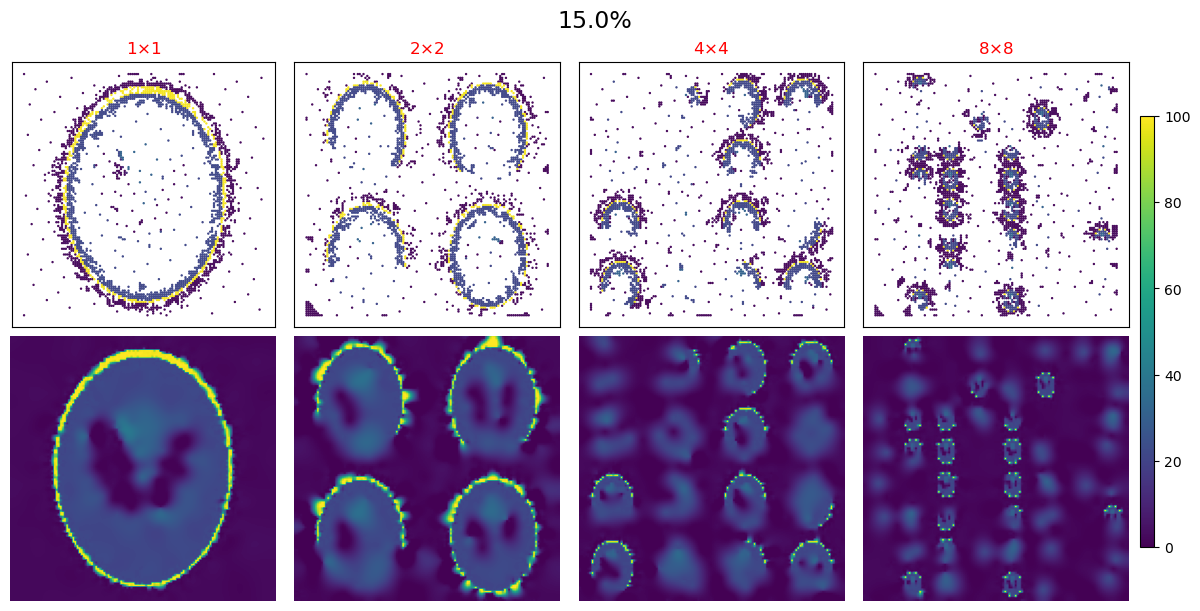

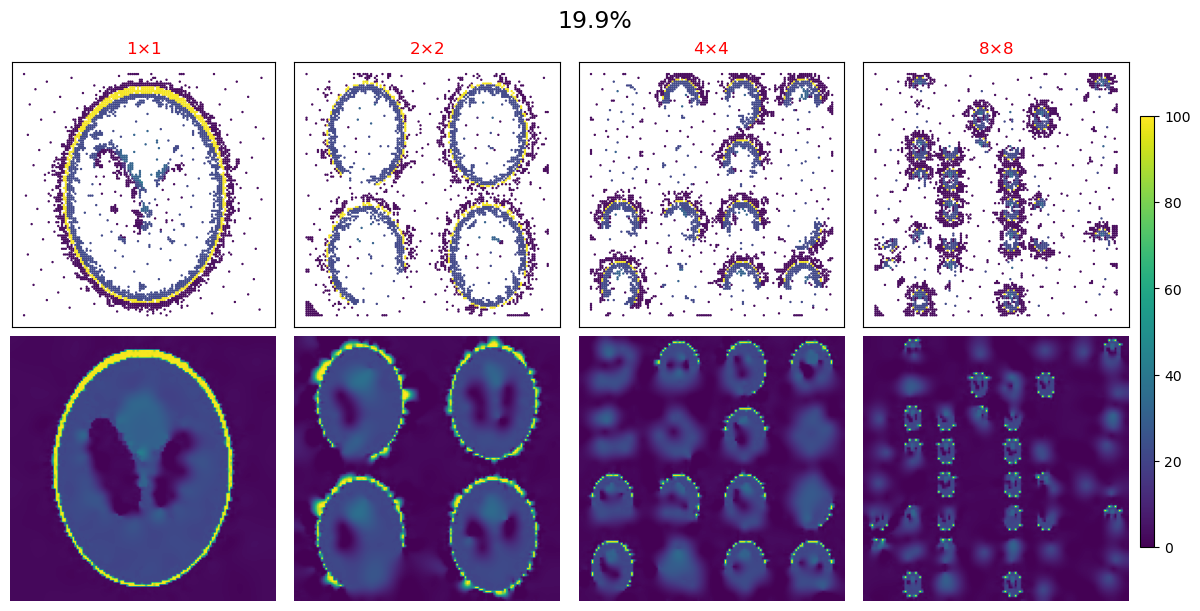

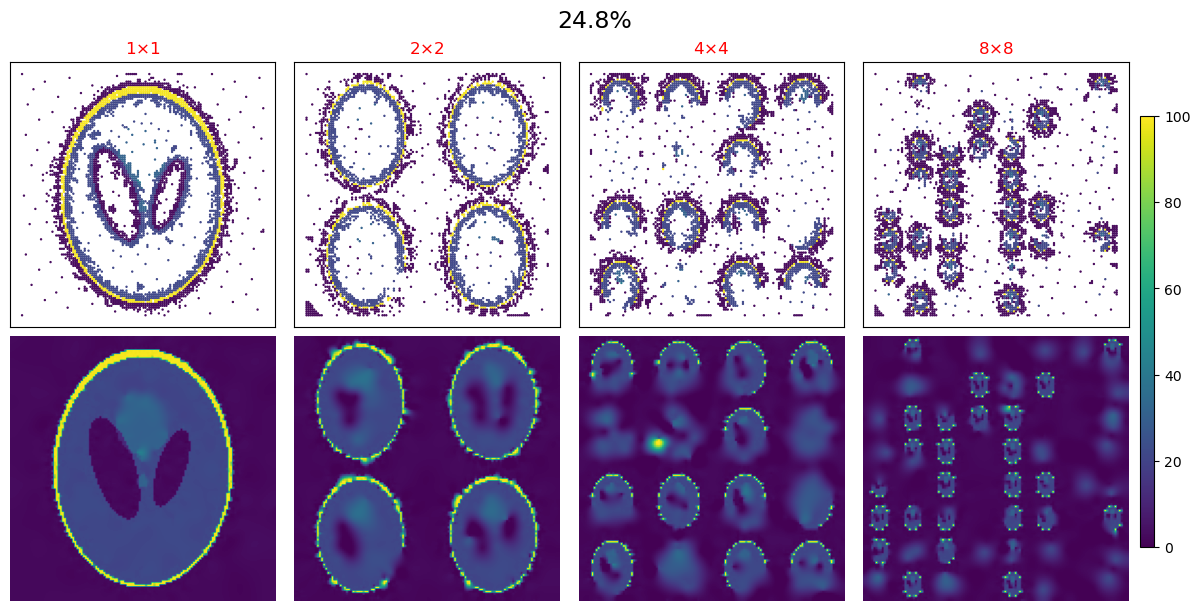

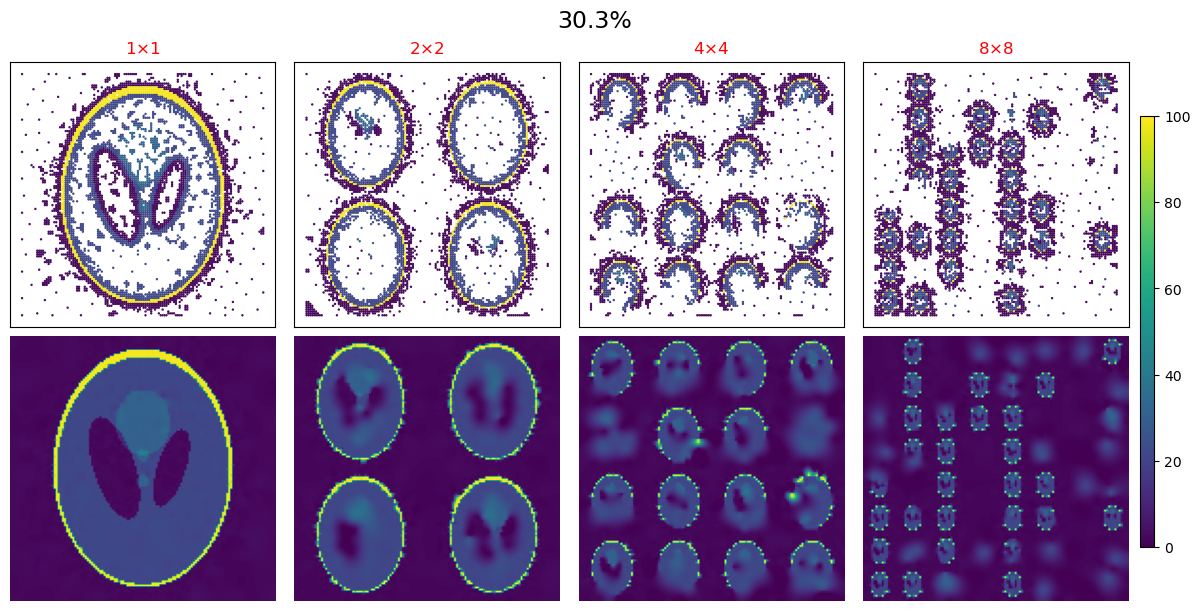

In [33]:
for ix, sr in enumerate(data_per_label[0]["scan_ratios"]):
    r_perc = sr * 100
    if ix not in indices:
        continue
    # if sr > 0.3 or ix==0: continue
    # if ix % 2 != 0: continue
    fig, axs = plt.subplots(2, 4, figsize=[12, 6], constrained_layout=True)
    cmap = mpl.colormaps.get_cmap("viridis").copy()
    norm = plt.Normalize(0, 100)
    for iy, label in enumerate(data_per_label):
        shape_this = shapes_scaled[label]
        roi = [np.maximum(center[0] - shape_this[0] // 2, 0), np.minimum(center[0] + shape_this[0] // 2, shape[0])]

        mask = data_per_label[label]["masks"][ix]  # [roi[0]: roi[1], roi[0]: roi[1]]
        recons = data_per_label[label]["recons_bh"][ix]  # [roi[0]: roi[1], roi[0]: roi[1]] / 100

        ypoints, xpoints = np.where(mask)

        ints = recons[ypoints, xpoints]

        # help(mpl.colors.Normalize)
        # raise

        # axs[0, iy].imshow(, rasterized=True)
        shape_this = shapes_scaled[iy]
        label = rf"{2**iy}$\times${2**iy}"
        axs[0, iy].scatter(xpoints, ypoints, c=ints, norm=norm, cmap=cmap, s=0.5, rasterized=False, zorder=0)
        axs[0, iy].set_title(label, c="r")
        axs[0, iy].set_aspect("equal")
        # axs[0, iy].set_ylim(roi[0], roi[1])
        # axs[0, iy].set_xlim(roi[0], roi[1])
        axs[0, iy].invert_yaxis()
        # axs[0, iy].axis('off')
        axs[0, iy].set_xticks([])
        axs[0, iy].set_yticks([])

        cim = axs[1, iy].imshow(recons, cmap=cmap, norm=norm, rasterized=False)
        # axs[1, iy].set_ylim(roi[0], roi[1])
        # axs[1, iy].set_xlim(roi[0], roi[1])
        axs[1, iy].axis("off")
    fig.suptitle(f"{sr * 100:3.1f}%", fontsize=17)
    fig.colorbar(cim, ax=axs, shrink=0.8, pad=0.01, use_gridspec=True, aspect=30)
    # plt.savefig(f"{base_dir}/comparisons_{r_perc:3.0f}.svg", bbox_inches="tight", dpi=400, transparent=True)
    plt.savefig(f"{base_dir}/comparisons_{r_perc:3.0f}.pdf", bbox_inches="tight", dpi=300, transparent=True)
    plt.show()